In [28]:
%reload_ext autoreload
%autoreload 2

# Ejercicio 1: Clasificación con redes bayesianas y cálculo de probabilidades condicionales

El objetivo de estos dos notebook is comprender y poder predecir la pérdida de clientes par una compañía telefónica. En este caso se procederá de la siguiente forma:

- Se divide en dos notebooks (010_churn_dataset_exploration y 012_churn_modelling). El primero contendrá el análisis de datos asíc omo su preprocesado para su posterior modelización. El segudo contendrá los pasos necesarios pars crear el modelo predecir la pérdida de clientes y estimar la métricas objetivas relativas a dichas predicciones.
- En este notebook `010_churn_dataset_exploration` se realiará los siguientes pasos:
 - División de los datos en train y test
 - Estimación de las variables más relevantes
 - Análisis de las variables numéricas, categóricas y entre ellas
 - Preprocesado y categorización de las variables continas
 - Guardado del nuevo dataset.

 Se procede inicialmente a la carga de librerías

Se procede a cargar las librerías necesarias

In [29]:
# Import libraries
import pandas as pd
import churn.config as cfg
from ydata_profiling import ProfileReport
from churn.paths import create_directories, DATA_DIR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from churn.preprocessing import load_data
from churn.plot import plot_barcharts, plot_boxplots
import plotly.express as px
import numpy as np
from pathlib import Path
from churn.analytics import (
    cramers_v_for_unique_pairs, 
    correlation_matrix, 
    relationships_cat_vs_num, 
    analyze_features, 
    print_best_results, 
    fit_best_discretizers, 
    create_binned_dataset,
    compare_variances
)
%matplotlib inline

Se crea el directorio donde se encuentra el dataset

In [30]:
# Path to the raw data
create_directories()
file_path = Path(DATA_DIR / 'churn.parquet')

2024-09-11 13:06:35,162 - INFO - Folder "data" ensured at "/Users/borja/Documents/Somniumrema/projects/ml/churn/data"
2024-09-11 13:06:35,163 - INFO - Folder "models" ensured at "/Users/borja/Documents/Somniumrema/projects/ml/churn/models"


Se cargan los datos del mismo y se comprueban las primeras filas con el fin de tener un primer aceercamiento a los mismos.

In [31]:
# Load the raw data
raw = load_data(file_path) 
# Display the first rows of the raw data
raw.head()

2024-09-11 13:06:37,111 - INFO - Data loaded from /Users/borja/Documents/Somniumrema/projects/ml/churn/data/churn.parquet


,area_code,plan,n_sms,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,customer_service_calls,customer_service_rating,customer_hapiness,churn
237522,5.0,2.0,724,1365.991021,203,50.449691,681.643301,140,33.122690,157.639198,53,25.163988,14,8,0.298234,0
847276,2.0,3.0,387,1253.394397,158,77.050620,437.941533,88,20.629900,220.159029,32,58.178678,0,8,0.424740,0
242450,8.0,1.0,490,627.687099,165,42.508170,618.231970,54,17.826781,178.298004,85,47.785126,32,5,0.378805,1
377221,3.0,1.0,822,601.816333,115,72.020707,605.255759,106,27.550356,212.695526,30,6.765252,25,9,0.175085,0
991506,1.0,2.0,455,951.019715,140,44.885685,320.538743,75,25.209541,217.364011,98,25.802669,36,6,0.612607,0


Se puede observar como en el caso anterior que existen 16 variables incluyendo la variable objetivo. Como se puede observar el dataset contiene variables de localización, uso, pago y relación con el cliente. Se observa lo siguiente:
- Las variables de uso dichas variables comprenden los minutos u llamdas realizadas en distintos tramos horarios ('day' entre 8h y 19h, 'eve' entre 19h y 22h y 'night' entre 22h y 8h) así como en níumero de mensajes enviados `n_sms`. Adicionalmente las mismas tienen una precisión que se analizará y corregirá posteriormente. Adicionalmente existe una variable categórica `plan` que describe la tarifa empleada por los clientes, que será tratada como categórica.
- La variable de localización únicamente contiene un código de area para los clientes `area_code` que será tratada como categórica.
- las variables de relación con el cliente `customer_service_calls`, `customer_service_rating` y `customer_hapiness` considerna no solamente el número de llamadas realizadas por el cliente al servicio al cliente sino también la calificación de la calidad de la servicio y la satisfacción del cliente.

Por último cabe mencionar la variable `churn` variable objetivo de las acciones que se planteen en este experimento.

Se realiza un primer análisis de las variables para ver la calidasd de los datos.

In [32]:
# Generate profile report
profile = ProfileReport(raw, title="Churn Dataset Report")

# Save the profile report to file
path = Path(DATA_DIR / 'churn_dataset_report.html')
profile.to_file(path)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

De dicho análisis, se establece un preprocesado mínimo, como el cambio de nombre de las variables así como mejorar la comprensibilidad de las variables existentes. Se observa que no existen relaciones significativas repsecto a las variables, no existen duplicados ni valores faltantes. Si bien existen valores atípicos en variables de uso del servicio (llamadas de telefono, etc) estos se mantendrán por el momento al tramear las variables. En caso necesario se tratarán con posterioridad. 

In [33]:
# Rename column 'customer_hapiness' and apply the correct type to the variables
raw = (raw
       .rename(columns={'customer_hapiness': 'customer_happiness'})
       .assign(
    area_code=lambda df: df['area_code'].astype('category'),
    plan=lambda df: df['plan'].astype('category'),
    churn=lambda df: df['churn'].astype('category'),
    total_day_minutes=lambda df: df['total_day_minutes'].round(),
    total_day_calls=lambda df: df['total_day_calls'].round(),
    total_day_charge=lambda df: df['total_day_charge'].round(2),
    total_eve_minutes=lambda df: df['total_eve_minutes'].round(),
    total_eve_calls=lambda df: df['total_eve_calls'].round(),
    total_eve_charge=lambda df: df['total_eve_charge'].round(2),
    total_night_minutes=lambda df: df['total_night_minutes'].round(),
    total_night_calls=lambda df: df['total_night_calls'].round(),
    total_night_charge=lambda df: df['total_night_charge'].round(2))
)

## Dividir los datos de partida en dos muestras entrenamiento y test

Se dividen los datos de partida en dos muestras siguiendo una semillas 123, un split para el test del 25% y la división estratificada basada en la variable `churn` al ser la variable objetivo

In [34]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    raw.drop(columns='churn'), 
    raw['churn'], 
    test_size=cfg.TEST_SIZE, 
    random_state=cfg.SEED, 
    stratify=raw['churn']
)

Los sets de train y test se conbina la variable target `churn` con las variables explicativas en un único dataset por comodidad. En el entrenamiento del modelo se separarán posteiormente para su correcta utilización

In [35]:
# Combine X_train and y_train for further analysis
train_data = X_train.copy()
train_data['churn'] = y_train.values

# Combine X_test and y_test for future use
test_data = X_test.copy()
test_data['churn'] = y_test.values

# Show the shapes of the resulting splits
train_data.shape, test_data.shape

((5625, 16), (1875, 16))

Se procede a la separación de variables numéricas y categóricas para su análisis posteiore

In [36]:
# Identify numeric variables
numeric_data_train = train_data.select_dtypes(include=[np.number])
# Identify categorical variables
categorical_data_train = train_data.select_dtypes(include=['category'])

## Preprocesado:
En este caso se comenzará estudiando la posible multicolinealidad lineal entre las variables predictoras. Psra ello se empleará el coeficiente de correlación de Pearson.

Se realiza la matriz de confusión de las variables numéricas, es decir se excluyen `churn`, `plan` y `area_code`. Su tratamiento como numéricas y correlación existente, aunque no tiene sentido, se encuentra recogido en el informe inicial de calidad de datos y profiling realizado. Las dos variables categóricas no tienen una correlación significativa con `churn` cuando las mismas se tratan como numéricas.

2024-09-11 13:06:55,099 - INFO - Correlation matrix calculated using method: pearson


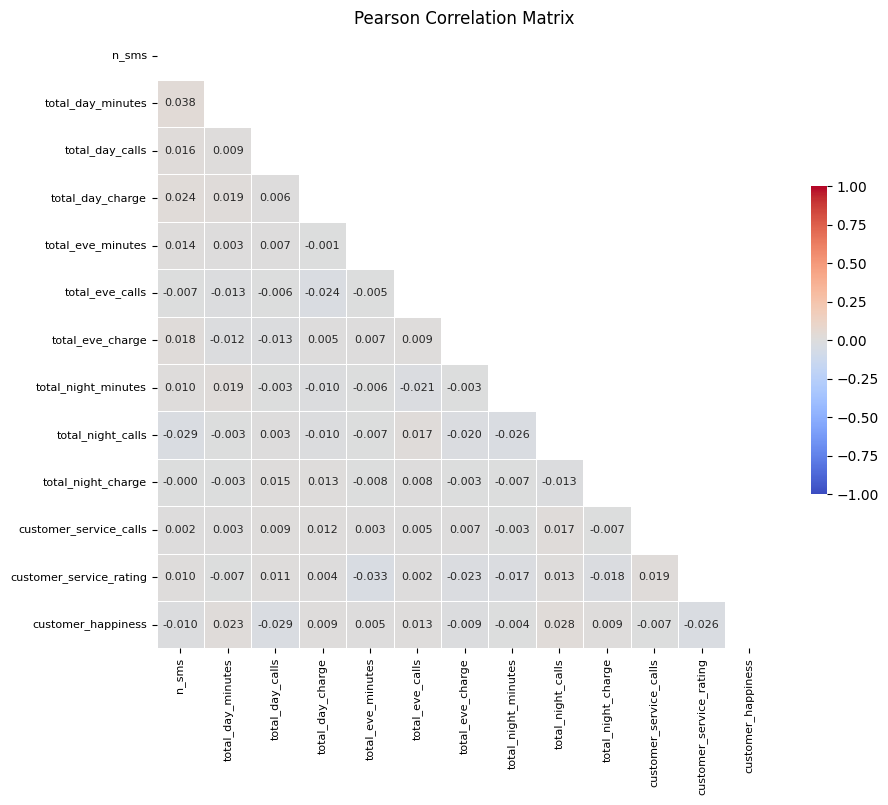

In [37]:
# Plot the correlation matrix of numeric variables
correlation_matrix(numeric_data_train, 'pearson', cfg.FIG_SIZE,'coolwarm', True, '.3f', 8, False)   

Se puede observar que no existen correlaciones significativas entre las variables numéricas. Se procede a calcular la V de Cramer en las variables numéricas.

In [38]:
# Calculate the Cramer's V for unique pairs of categorical variables
cramer_v_categorical = cramers_v_for_unique_pairs(train_data)
    
# Show results
cramer_v_categorical

2024-09-11 13:06:55,379 - INFO - Categorical columns: Index(['area_code', 'plan', 'churn'], dtype='object')


{'area_code_vs_plan': 0.0, 'area_code_vs_churn': 0.0, 'plan_vs_churn': 0.0}

Se observa que no existe un valor de la V de Cramer significativo ente las variables categóricas. Se procede al análisis de las relaciones existentes entre las variables categóricas y numéricas. Para ello, en funciòn de las condiciones de normalidad y homogeniedad se utilizará en test ANOVA uy Krustal-Wallis. Se entre todas ellas únicamente se seleccionarán aquellas que sean sigifnicativas en sus relaciones (p<0.05)

In [39]:
# Identify relationships between categorical and numeric variables
test_results_df = relationships_cat_vs_num(train_data, categorical_data_train, numeric_data_train)

# Filter the DataFrame to only show significant relationships
significant_results_df = test_results_df[test_results_df['P-Value'] < 0.05]

# Show results
significant_results_df

,Categorical Variable,Numerical Variable,Test Used,P-Value
22,plan,total_night_charge,Kruskal-Wallis,4.338924e-02
36,churn,customer_service_calls,Kruskal-Wallis,4.717166e-215
37,churn,customer_service_rating,Kruskal-Wallis,1.067591e-21
38,churn,customer_happiness,Kruskal-Wallis,7.862490e-59


De entre todas ellas se observa que solamente existen relaciones significativas entre las variables de satisfacción y relación con el cliente `customer_service_calls`, `customer_service_ratings` y `customer_happiness` con la variable `churn`. Sin embargo, existe una relación significativa entre el coste de las llamadas nocturnas y el plan suscrito. No existe con otros cargos para otros tramos del día. Se proicede a analizar de forma gráfica dichas variables

In [40]:
# Plot boxplots for numeric variables vs the target variable
plot_boxplots(train_data, numeric_data_train)

Se puede observar que en general considerando fuga o no, para las variables de uso los valors medios son muy similares para todas las variables de uso. No existen diferencias significativas entre los valores medios dependiendo de la existencia de fuga o no. en lo que respecta a la variables de interacción con el cliente, se observa que existen medias significativamente diferenciada para las variables `customer_service_calls`, `customer_service_ratings` y `cusotmer_happiness` en función de la categoría de fuga o no fuga del cliente.

En lo que respecta a las variables categóricas `area_code`, `plan` y `customer_service_rting` (se le ha dado un tratamiento como numérica y como categíroica para entender mejor su utilización posterior). 

In [41]:
# Select categorical variables (including customer_service_rating) to plot
variables_to_plot = train_data[['area_code','plan','customer_service_rating']]

# Plor barcharts
plot_barcharts(train_data, variables_to_plot, 'churn')

Se observa que el `churn` se mantiene relativamente constante con la distribución de clientes por `area_code`. No hay varaciones significativas en lo que a chrn se refiere pero hay valores relativamente menores para areas 1, 5 y 7.
En lo que se refiere a la distribución de `plan` por `churn`, se observa que para los planes 1 y 2 se mantiene en los mismos niveles pero ser reduce para el caso del plan 3.
En lo que respecta a la distribución de `customer_service_rtings`, se ver que la acumulación de clientes fugados es relativamente mayor para valores de 5 disminuyendo pars valores anteriores y posteriores. Existe un ligero incremento entre valores de esta variable de 6 a 7. 

Se realiza una selección de las 7 características más relevamtes. Para ellos, se entrena un modelo random forest básico con un número de estiadores de 50, profundidad de 6 y semilla para su reproducibilidad. De las características ranqueadas, se escogerán las siete primeras.

In [42]:
# Instantiate Random Forest model with the specified hyperparameters
rf_model = RandomForestClassifier(n_estimators=cfg.ESTIMATORS,
                                  max_depth=cfg.DEPTH,
                                  random_state=cfg.SEED
                                  )

# Train the model
rf_model.fit(X_train, y_train)

# Obtain feature importances from the model
importances = rf_model.feature_importances_

# Sort the feature importances in descending order and select only the top 7
indices = np.argsort(importances)[-cfg.NUM_FEATURES:] 

# Select the features corresponding to the top 7 importances
features = X_train.columns[indices]

# Print the top 7 features
features

Index(['total_day_minutes', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'customer_service_rating', 'customer_happiness',
       'customer_service_calls'],
      dtype='object')

Las variables más significativas para el modelos son las siguientes `total_day_charge`, `total_eve_minutes`, `total_eve_calls`, `customer_service_rating`, `customer_happiness` y `customer_service_calls`. Se representan los mismos para conocer y ver las características más significativas con las que se entrenará el modelo. Las mismas incluyen todas las variables de interrelación con el ususario y imícamente dos de uso (por la tarde) y una de tarificación durante el día.

In [43]:
# Graph showing the feature importance of the top 7 features
fig = px.bar(
    x=importances[indices],
    y=features,
    orientation='h',
    labels={'x': 'Feature Importance', 'y': 'Features'},
    color_discrete_sequence=['cornflowerblue']  # Set bar color to blue
)

# Update layout to make the chart smaller and set black background
fig.update_layout(
    height=400, 
    width=900, 
    title_text='Feature Importance (Random Forest)',
    **cfg.PLOTLY_LAYOUT_CONFIG
)

# Plot the graph
fig.show()

Se observa que la contribución de las variables de relación con el cliente y su satisfacción es significativamente mayor que la del resto de las características seleccionadas. Aunque el resto ha sido incluido, la contribución de las mismas es significativamente menor. Se procederá a la categorización de estas variables considerando la restricción existente de tener como mínimo cuatro tramos. Para ello, se automatizará la busqueda del número de tramos así como estrategia de categorización (igualdad de frecuencias, igualdad de longitud de tramos, geométrica, etc.) que maximice la V de Cramer entre las variables una vez categorizadas ya que se persigue obtener el mejor modelo posible. Si bien moejrará el poder predictivo del modelo podría empeorar su explicabilidad.

In [44]:
# Create a DataFrame with the top 7 features and the target variable
train_features = X_train[features].copy()
train_features['churn'] = y_train.values

# Create a DataFrame with the top 7 features and the target variable
test_features = X_test[features].copy()
test_features['churn'] = y_test.values

Se considera la división anterior per solamente con las variables más significativas, ya que se empleará el set de entrenamiento para realizar el entrenamiento y tremeado de las variables y el mismo se aplicará a los datos de test.

In [48]:
# Create a copy of the training features
train_features = train_features.copy()

# Establish the bin range from 4 to _
bin_range = cfg.BIN_SIZES

# Establish the optimization step
opt_step = cfg.OPT_STEP

# Analyze the features and find the best discretizers
best_results = analyze_features(train_features, 'churn', bin_range, opt_step)

# Print the best results
print_best_results(best_results)

Feature: customer_service_calls, Best Cramér's V: 0.6108 with 6 bins using geometric_width strategy
Feature: customer_happiness, Best Cramér's V: 0.2360 with 8 bins using equal_width strategy
Feature: customer_service_rating, Best Cramér's V: 0.2209 with 4 bins using equal_width strategy
Feature: total_day_minutes, Best Cramér's V: 0.0367 with 8 bins using geometric_width strategy
Feature: total_eve_calls, Best Cramér's V: 0.0235 with 5 bins using equal_width strategy
Feature: total_eve_minutes, Best Cramér's V: 0.0198 with 4 bins using equal_width strategy
Feature: total_day_charge, Best Cramér's V: 0.0174 with 6 bins using equal_frequency strategy


Se observa que la estrategía más común para las variables empleadas es la de tramos de igual longitud con un número de tramos variable entre 4 y 8. En el caso de la estrategia geométrica, el número de tramos oscial entre 6 y 8. Se puede observar una mejora significativa de la V de Cramer en las variables relativas a la relación con el cliente menitras que dicha relación no mejora significativamente en el resto de las variables (tarifa y uso).

In [49]:
# Compare the variances of the original dataset with the binned dataset
variance_comparison = compare_variances(best_results, train_features, 'total_eve_minutes')

# Show the comparison
display(variance_comparison)

,Bin,Bin_Edges,Within Bin Variance,Original_Variance
0,0,-inf - 346.75,7240.283815,43719.631732
1,1,346.75 - 693.5,8880.976964,43719.631732
2,2,693.5 - 1040.25,7536.371418,43719.631732
3,3,1040.25 - inf,4518.310737,43719.631732


A modo de ejemplo (aunque se ha realizado con todas ellas) se analiza la varianza inter tramos frente a la total. Se observa que para todas las estrategias utilizadas la varianza entre tramos es menor que la original por lo que la estrategia de trameadop y el número de tramos es adecuado en este respecto. Una vez elegida y analizada la mejor estrategia, el categorizados se entrena en los datos de entrenamiento.

In [50]:
# Fit the best discretizers to the training features
fitted_discretizers = fit_best_discretizers(train_features, best_results, 'churn')

# Create the new binned training dataset
train_features_binned = create_binned_dataset(train_features, fitted_discretizers, 'churn')

# Display the new dataset with binned features
train_features_binned.head()

,churn,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_calls,customer_service_rating,customer_happiness,customer_service_calls
497788,0,6,5,1,0,3,1,0
69163,0,6,3,1,1,1,0,0
346342,0,7,0,1,2,3,5,0
59207,1,7,3,1,2,3,0,5
682551,0,7,5,1,1,3,2,3


Se realiza un profiling para ver que la calidad de los datos es adecuada y que no se han producido errores. Las variables han sido trameadas correctamente.

In [51]:
# Generate profile report for raw features (pre-binning)
raw_features_report = ProfileReport(train_features, title="Raw_Feat")

# Generate profile report for binned features
binned_features_report = ProfileReport(train_features_binned, title="Binned_Feat")

# Compare both datsets
comparison_report = raw_features_report.compare(binned_features_report)

# Save report to file
path = Path(DATA_DIR / 'comparison_raw_binned_features.html')
comparison_report.to_file(path)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Se procede a anaizar la relación entre las variables trameadas y la variable objetivo.

In [54]:
# Convert all columns to categorical
train_features_binned = train_features_binned.astype('category')

# Save to file the new binned dataset
path = Path(DATA_DIR / 'train_features_binned.parquet')
train_features_binned.to_parquet(path, index=False)

# Calculate the Cramer's V for unique pairs of categorical variables
cramer_v_features = cramers_v_for_unique_pairs(train_features_binned)

# Convert the dictionary to a DataFrame
features_comparison = pd.DataFrame(list(cramer_v_features.items()), columns=['Pair', 'Cramers_V'])

# Sort the DataFrame by Cramer's V in descending order
features_comparison = features_comparison.sort_values(by='Cramers_V', ascending=False)

# Show the features comparison
features_comparison

2024-09-11 13:19:06,199 - INFO - Categorical columns: Index(['churn', 'total_day_minutes', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'customer_service_rating', 'customer_happiness',
       'customer_service_calls'],
      dtype='object')


,Pair,Cramers_V
6,churn_vs_customer_service_calls,0.610824
5,churn_vs_customer_happiness,0.236049
4,churn_vs_customer_service_rating,0.220856
0,churn_vs_total_day_minutes,0.036682
18,total_eve_minutes_vs_total_eve_calls,0.031475
25,customer_service_rating_vs_customer_happiness,0.025449
22,total_eve_calls_vs_customer_service_rating,0.023804
12,total_day_minutes_vs_customer_service_calls,0.023647
3,churn_vs_total_eve_calls,0.023511
8,total_day_minutes_vs_total_eve_minutes,0.022941


Se observan las variables trameadas en función de su V de Cramer. Se observa que las variables han incrementando su relación con la variable objetivo con el trameado. Este efecto es más significativo en el caso de variables de relación con el cliente y mucho menos significativo aunque existente en aquellas variables de uso. El trameado de las mismas no ha introducido relaciones significativas entre las características más importantes que afecten al modelo. 

In [55]:
# Save the profile report to file
path = Path(DATA_DIR / 'train_features_binned_report.html')
binned_features_report.to_file(path)

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
# Filter the DataFrame to include only pairs with Cramér's V > 0.10
features_comparison = features_comparison[features_comparison['Cramers_V'] > cfg.RELATIONSHIP_THRESHOLD]

# Show results
features_comparison

,Pair,Cramers_V
6,churn_vs_customer_service_calls,0.610824
5,churn_vs_customer_happiness,0.236049
4,churn_vs_customer_service_rating,0.220856


Como se vio en la tabla anterior, unicamente aquellas relacionadas con la calidad de servicio e interacción con el cliente tienen valores de V de Cramer superiores al 10%.

Se procede a aplicar la misma estrategia de binarización sobre las características del test set con el modelo de categorización anteriormente entrenado en el set de entrenamiento.

In [24]:
# Create the new binned training dataset
test_features_binned = create_binned_dataset(test_features, fitted_discretizers, 'churn')

# Convert all columns to categorical
test_features_binned = test_features_binned.astype('category')

# Save to file the new binned dataset
path = Path(DATA_DIR / 'test_features_binned.parquet')
test_features_binned.to_parquet(path, index=False)

Se procede en el notebook 012_churn_modelling al modelado y predicción de churn.